In [ ]:
!git clone https://github.com/ultralytics/ultralytics.git
%cd /content/ultralytics
!pip install -e.

In [ ]:
from tqdm.auto import tqdm

import os
import requests
import zipfile
import cv2
import math
import matplotlib.pyplot as plt
import glob
import numpy as np
import random

from PIL import Image

In [ ]:
# Project main folder (repo root)
ROOT_DIR = os.path.dirname(os.path.abspath(__file__))

# Dataset paths
train_imgs_dir = os.path.join(ROOT_DIR, "../data/images/train")
train_labels_dir = os.path.join(ROOT_DIR, "../data/labels/train")
val_imgs_dir = os.path.join(ROOT_DIR, "../data/images/val")
val_labels_dir = os.path.join(ROOT_DIR, "../data/labels/val")
test_imgs_dir = os.path.join(ROOT_DIR, "../data/images/test")
test_labels_dir = os.path.join(ROOT_DIR, "../data/labels/test")

# Class names and colors
classes = ['Person', 'Car', 'Bicycle', 'OtherVehicle']  # DontCare kaldırıldı
colors = np.random.uniform(0, 255, size=(len(classes), 3))


In [ ]:
# Creating a CLAHE object (Arguments are optional)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

def apply_clahe_and_remove_dontcare(image_dir, label_dir):
    image_paths = sorted(glob.glob(os.path.join(ROOT_DIR, image_dir, '*.jpg')))
    label_paths = sorted(glob.glob(os.path.join(ROOT_DIR, label_dir, '*.txt')))

    for img_path, label_path in tqdm(zip(image_paths, label_paths), total=len(image_paths), desc=f"Processing {image_dir}"):
        img = cv2.imread(img_path)
        if img is None:
            continue
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        cl = clahe.apply(l)
        limg = cv2.merge((cl, a, b))
        final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
        cv2.imwrite(img_path, final)

        with open(label_path, 'r') as f:
            lines = f.readlines()
        cleaned = [line for line in lines if not line.startswith('4 ')]
        with open(label_path, 'w') as f:
            f.writelines(cleaned)

apply_clahe_and_remove_dontcare(train_imgs_dir, train_labels_dir)
apply_clahe_and_remove_dontcare(val_imgs_dir, val_labels_dir)
apply_clahe_and_remove_dontcare(test_imgs_dir, test_labels_dir)


In [ ]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [ ]:
def plot_box(image, bboxes, labels, classes=classes, colors=colors, pos='above'):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    height, width, _ = image.shape
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)  # Line width.
    tf = max(lw - 1, 1) # Font thickness.
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*width)
        ymin = int(y1*height)
        xmax = int(x2*width)
        ymax = int(y2*height)

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))

        class_name = classes[int(labels[box_num])]

        color=colors[classes.index(class_name)]

        cv2.rectangle(
            image,
            p1, p2,
            color=color,
            thickness=lw,
            lineType=cv2.LINE_AA
        )

        # For filled rectangle.
        w, h = cv2.getTextSize(
            class_name,
            0,
            fontScale=lw / 3,
            thickness=tf
        )[0]

        outside = p1[1] - h >= 3

        if pos == 'above':
            p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
            cv2.rectangle(
                image,
                p1, p2,
                color=color,
                thickness=-1,
                lineType=cv2.LINE_AA
            )
            cv2.putText(
                image,
                class_name,
                (p1[0], p1[1] - 5 if outside else p1[1] + h + 2),
                cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=lw/3.5,
                color=(255, 255, 255),
                thickness=tf,
                lineType=cv2.LINE_AA
            )
        else:
            new_p2 = p1[0] + w, p2[1] + h + 3 if outside else p2[1] - h - 3
            cv2.rectangle(
                image,
                (p1[0], p2[1]), new_p2,
                color=color,
                thickness=-1,
                lineType=cv2.LINE_AA
            )
            cv2.putText(
                image,
                class_name,
                (p1[0], p2[1] + h + 2 if outside else p2[1]),
                cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=lw/3,
                color=(255, 255, 255),
                thickness=tf,
                lineType=cv2.LINE_AA
            )
    return image

In [ ]:
# Function to plot images with the bounding boxes.
def plot(image_path, label_path, num_samples, classes=classes, colors=colors, pos='above'):
    all_training_images = glob.glob(image_path+'/*')
    all_training_labels = glob.glob(label_path+'/*')
    all_training_images.sort()
    all_training_labels.sort()

    temp = list(zip(all_training_images, all_training_labels))
    random.shuffle(temp)
    all_training_images, all_training_labels = zip(*temp)
    all_training_images, all_training_labels = list(all_training_images), list(all_training_labels)

    num_images = len(all_training_images)

    if num_samples == -1:
        num_samples = num_images

    num_cols = 2
    num_rows = int(math.ceil(num_samples / num_cols))

    plt.figure(figsize=(10 * num_cols, 6 * num_rows))
    for i in range(num_samples):
        image_name = all_training_images[i].split(os.path.sep)[-1]
        image = cv2.imread(all_training_images[i])
        with open(all_training_labels[i], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label, x_c, y_c, w, h = label_line.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels, classes, colors, pos)
        plt.subplot(num_rows, num_cols, i+1) # Visualize 2x2 grid of images.
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# Visualize a few training images.
plot(
    image_path=os.path.join(ROOT_DIR, train_imgs_dir),
    label_path=os.path.join(ROOT_DIR, train_labels_dir),
    num_samples=8
)

In [ ]:
%%writefile dataset.yaml

path: /content/drive/MyDrive/Colab Notebooks/hit-uav
train: images/train
val: images/val
test: images/test
nc: 4
names:
  0: Person
  1: Car
  2: Bicycle
  3: OtherVehicle

Overwriting dataset.yaml


In [ ]:
# Weights & Biases logging disabled to avoid errors if wandb is not installed
os.environ['WANDB_DISABLED'] = 'true'

In [ ]:
from ultralytics import YOLO

# Install the basic yolov8m model 
model = YOLO('yolov8m.pt')  

# Start training 
model.train(
    data='dataset.yaml',
    imgsz=512,
    epochs=10,
    batch=16,
    name='warmup_yolov8m'
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 49.7M/49.7M [00:00<00:00, 160MB/s]


Ultralytics 8.3.137 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=warmup_yolov8m, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, 

100%|██████████| 755k/755k [00:00<00:00, 98.2MB/s]

Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

  8                  -1  2   3985920  ultralytics.nn.modules.block.C2f             [576, 576, 2, True]           
  9                  -1  1    831168  ultralytics.nn.modules.block.SPPF            [576, 576, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  2   1993728  ultralytics.nn.modules.block.C2f             [960, 384, 2]                 
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  2    517632  ultralytics.nn.modules.block.C2f             [576, 192, 2]                 
 16                  -1  1    332160  ultralytics.nn.modules.conv.Conv             [192,

100%|██████████| 5.35M/5.35M [00:00<00:00, 378MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.3±0.1 ms, read: 0.1±0.0 MB/s, size: 90.6 KB)


train: Scanning /content/drive/MyDrive/Colab Notebooks/hit-uav/labels/train.cache... 2008 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2008/2008 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 0.1±0.0 MB/s, size: 106.4 KB)


val: Scanning /content/drive/MyDrive/Colab Notebooks/hit-uav/labels/val.cache... 287 images, 0 backgrounds, 0 corrupt: 100%|██████████| 287/287 [00:00<?, ?it/s]


Plotting labels to /content/ultralytics/runs/detect/warmup_yolov8m/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 8 dataloader workers
Logging results to /content/ultralytics/runs/detect/warmup_yolov8m
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.11G      1.674      1.606      1.112         95        512: 100%|██████████| 126/126 [01:28<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.69it/s]

                   all        287       2453      0.765      0.468      0.544      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.79G      1.595      1.146      1.091        128        512: 100%|██████████| 126/126 [00:42<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.37it/s]

                   all        287       2453      0.722      0.439      0.455      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50       4.8G      1.598       1.11      1.087        105        512: 100%|██████████| 126/126 [00:41<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.39it/s]

                   all        287       2453      0.691      0.357       0.39      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.86G      1.563      1.057      1.073        115        512: 100%|██████████| 126/126 [00:41<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.50it/s]

                   all        287       2453      0.787      0.472      0.533      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.94G      1.546      1.003       1.06        150        512: 100%|██████████| 126/126 [00:41<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.42it/s]

                   all        287       2453      0.813      0.479      0.572      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.99G      1.481     0.9583       1.05         75        512: 100%|██████████| 126/126 [00:41<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.46it/s]

                   all        287       2453      0.808      0.523      0.613       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.07G      1.454     0.9251      1.032         81        512: 100%|██████████| 126/126 [00:41<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.50it/s]

                   all        287       2453      0.821      0.583      0.674      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.12G      1.415     0.8636      1.018         95        512: 100%|██████████| 126/126 [00:42<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.43it/s]

                   all        287       2453      0.827      0.508      0.572      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.12G       1.41     0.8673      1.008        103        512: 100%|██████████| 126/126 [00:41<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.48it/s]

                   all        287       2453      0.671      0.718      0.724      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.12G      1.379     0.8302      1.011         89        512: 100%|██████████| 126/126 [00:41<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.51it/s]

                   all        287       2453      0.751      0.688      0.738       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.12G      1.363     0.8061      1.002        125        512: 100%|██████████| 126/126 [00:41<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.51it/s]

                   all        287       2453      0.648      0.681       0.71      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.12G      1.352     0.8029     0.9949        104        512: 100%|██████████| 126/126 [00:41<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.48it/s]

                   all        287       2453       0.73      0.671      0.715      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.12G      1.358     0.7824     0.9845        119        512: 100%|██████████| 126/126 [00:41<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.37it/s]

                   all        287       2453      0.859      0.637      0.745      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.12G      1.316     0.7534     0.9859        134        512: 100%|██████████| 126/126 [00:41<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.50it/s]

                   all        287       2453      0.771       0.67       0.74      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.12G      1.294     0.7353     0.9815        153        512: 100%|██████████| 126/126 [00:41<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.54it/s]

                   all        287       2453      0.697      0.685      0.731      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.12G      1.285     0.7411     0.9754         77        512: 100%|██████████| 126/126 [00:41<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.47it/s]

                   all        287       2453      0.774        0.7      0.748      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.12G      1.285     0.7169      0.971        129        512: 100%|██████████| 126/126 [00:41<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.48it/s]

                   all        287       2453      0.836      0.754      0.828      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.12G      1.291     0.7126      0.977         53        512: 100%|██████████| 126/126 [00:41<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.51it/s]

                   all        287       2453      0.708      0.767      0.798      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.12G      1.265      0.704     0.9621        119        512: 100%|██████████| 126/126 [00:41<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.51it/s]

                   all        287       2453      0.824      0.738      0.809       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.12G      1.244     0.6875     0.9599        104        512: 100%|██████████| 126/126 [00:41<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.49it/s]

                   all        287       2453       0.79      0.725      0.785       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.12G      1.237     0.6724     0.9533         62        512: 100%|██████████| 126/126 [00:41<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.48it/s]

                   all        287       2453      0.823      0.709       0.79      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      5.12G      1.253     0.6773     0.9565        138        512: 100%|██████████| 126/126 [00:41<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.50it/s]

                   all        287       2453      0.759      0.803      0.818      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.12G      1.215     0.6568     0.9477        157        512: 100%|██████████| 126/126 [00:41<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.52it/s]

                   all        287       2453      0.793      0.807      0.838       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.12G      1.215     0.6563     0.9467        162        512: 100%|██████████| 126/126 [00:41<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.48it/s]

                   all        287       2453      0.815      0.807      0.846      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.12G      1.188     0.6366     0.9511        118        512: 100%|██████████| 126/126 [00:41<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.51it/s]

                   all        287       2453      0.811      0.756      0.823      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.12G      1.182      0.631     0.9396        113        512: 100%|██████████| 126/126 [00:41<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.53it/s]

                   all        287       2453      0.773      0.705      0.755      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.12G      1.163     0.6267     0.9361         61        512: 100%|██████████| 126/126 [00:41<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.46it/s]

                   all        287       2453      0.797      0.763      0.783      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.12G      1.156      0.617     0.9336        147        512: 100%|██████████| 126/126 [00:41<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.49it/s]

                   all        287       2453      0.824      0.697      0.767      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.12G      1.172     0.6138     0.9356         80        512: 100%|██████████| 126/126 [00:41<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.52it/s]

                   all        287       2453      0.867      0.737      0.833      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.12G      1.145     0.5972      0.932         72        512: 100%|██████████| 126/126 [00:41<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.43it/s]

                   all        287       2453      0.829      0.764      0.828      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.12G      1.139     0.5882     0.9262        224        512: 100%|██████████| 126/126 [00:41<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.49it/s]

                   all        287       2453      0.851      0.832      0.874      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.12G      1.137     0.5888     0.9236         88        512: 100%|██████████| 126/126 [00:41<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.51it/s]

                   all        287       2453      0.813      0.833      0.862      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.12G      1.129     0.5828      0.924        129        512: 100%|██████████| 126/126 [00:41<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.49it/s]

                   all        287       2453      0.842      0.791      0.832      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.12G      1.121     0.5711     0.9162        135        512: 100%|██████████| 126/126 [00:41<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.52it/s]

                   all        287       2453      0.863      0.822      0.873      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.12G      1.107     0.5666     0.9182         81        512: 100%|██████████| 126/126 [00:41<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.53it/s]

                   all        287       2453      0.873      0.803      0.868      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.12G      1.095     0.5564     0.9121        116        512: 100%|██████████| 126/126 [00:41<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.44it/s]

                   all        287       2453      0.882      0.817      0.863      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.12G      1.105     0.5582     0.9146        100        512: 100%|██████████| 126/126 [00:41<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.50it/s]

                   all        287       2453      0.829      0.831      0.855      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.12G      1.077     0.5498     0.9072         66        512: 100%|██████████| 126/126 [00:41<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.48it/s]

                   all        287       2453      0.907      0.738      0.844      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.12G      1.083      0.543     0.9113         94        512: 100%|██████████| 126/126 [00:41<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.46it/s]

                   all        287       2453       0.78      0.816      0.831      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.12G      1.066     0.5367     0.9042         94        512: 100%|██████████| 126/126 [00:41<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.49it/s]

                   all        287       2453      0.865      0.871      0.894      0.607


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.12G      1.072     0.5246     0.9143         75        512: 100%|██████████| 126/126 [00:42<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.49it/s]

                   all        287       2453      0.869      0.832      0.881      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      5.12G      1.062     0.5161      0.909         44        512: 100%|██████████| 126/126 [00:41<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.51it/s]

                   all        287       2453      0.898      0.763      0.871      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      5.12G       1.06      0.518     0.9077         37        512: 100%|██████████| 126/126 [00:41<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.47it/s]

                   all        287       2453      0.848      0.808      0.866      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      5.12G      1.045      0.498     0.9098        114        512: 100%|██████████| 126/126 [00:41<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.48it/s]

                   all        287       2453      0.852      0.769      0.859      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.12G      1.029     0.4906     0.9004         89        512: 100%|██████████| 126/126 [00:41<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.50it/s]

                   all        287       2453      0.866      0.794      0.863      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.12G      1.024     0.4875        0.9         79        512: 100%|██████████| 126/126 [00:41<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.50it/s]

                   all        287       2453      0.884      0.788      0.866      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      5.12G      1.015     0.4777     0.8963         66        512: 100%|██████████| 126/126 [00:41<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.52it/s]

                   all        287       2453      0.871      0.794      0.871      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      5.12G      1.005     0.4736     0.8929         51        512: 100%|██████████| 126/126 [00:41<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.49it/s]

                   all        287       2453      0.817      0.851      0.873      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.12G     0.9955     0.4726     0.8895         22        512: 100%|██████████| 126/126 [00:41<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.53it/s]

                   all        287       2453      0.826      0.855      0.882      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      5.12G      0.996     0.4657     0.8912         53        512: 100%|██████████| 126/126 [00:41<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.49it/s]

                   all        287       2453      0.809      0.884      0.884       0.61



50 epochs completed in 0.639 hours.
Optimizer stripped from /content/ultralytics/runs/detect/warmup_yolov8m/weights/last.pt, 52.0MB
Optimizer stripped from /content/ultralytics/runs/detect/warmup_yolov8m/weights/best.pt, 52.0MB

Validating /content/ultralytics/runs/detect/warmup_yolov8m/weights/best.pt...
Ultralytics 8.3.137 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.19it/s]


                   all        287       2453       0.81      0.884      0.884      0.611
                Person        171       1168      0.784      0.883      0.892      0.485
                   Car        136        719      0.917      0.986      0.988      0.767
               Bicycle         53        554       0.75      0.917      0.916      0.559
          OtherVehicle          9         12      0.791       0.75      0.741      0.631
Speed: 0.1ms preprocess, 5.3ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /content/ultralytics/runs/detect/warmup_yolov8m


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7abf29fd7290>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [ ]:
from ultralytics import YOLO

# Initialize YOLOv8 with a custom architecture file.
# In this case, 'yolov8m_cbam.yaml' defines a YOLOv8m model modified
# with the CBAM (Convolutional Block Attention Module).
# Similarly, other attention mechanisms (e.g., CoordAtt) can be tested
# by providing their corresponding custom YAML files.
# Pretrained weights ('yolov8m.pt') are loaded to apply transfer learning.

model = YOLO('yolov8m_cbam.yaml').load('yolov8m.pt')

# Start training 
model.train(
    data='dataset.yaml',
    imgsz=512,
    epochs=50,
    batch=16,
    hyp='hyp.yaml',           #Custom hyperparameters
    name='yolov8m_resnet50'
)


In [ ]:
from ultralytics import YOLO

# Load the trained model
model = YOLO("results/best.pt")

# Save prediction results (to txt files)
results = model.val(
    data="dataset.yaml",   # own dataset path
    imgsz=512,
    save_txt=True,         # Predictions will be saved as .txt files
    save_conf=True         # Report confidence scores as well
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
YOLOv8m_cbam summary (fused): 97 layers, 49,594,398 parameters, 0 gradients, 194.0 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 103MB/s]


val: Fast image access ✅ (ping: 0.4±0.2 ms, read: 0.1±0.0 MB/s, size: 85.1 KB)


val: Scanning /content/drive/MyDrive/Colab Notebooks/hit-uav/labels/val.cache... 287 images, 0 backgrounds, 0 corrupt: 100%|██████████| 287/287 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:09<00:00,  1.81it/s]


                   all        287       2453      0.885      0.782       0.86      0.579
                Person        171       1168      0.885      0.781      0.881      0.466
                   Car        136        719      0.955      0.952      0.985      0.756
               Bicycle         53        554       0.88      0.812       0.88      0.523
          OtherVehicle          9         12      0.817      0.583      0.695      0.569
Speed: 0.4ms preprocess, 7.2ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to /content/ultralytics/runs/detect/val


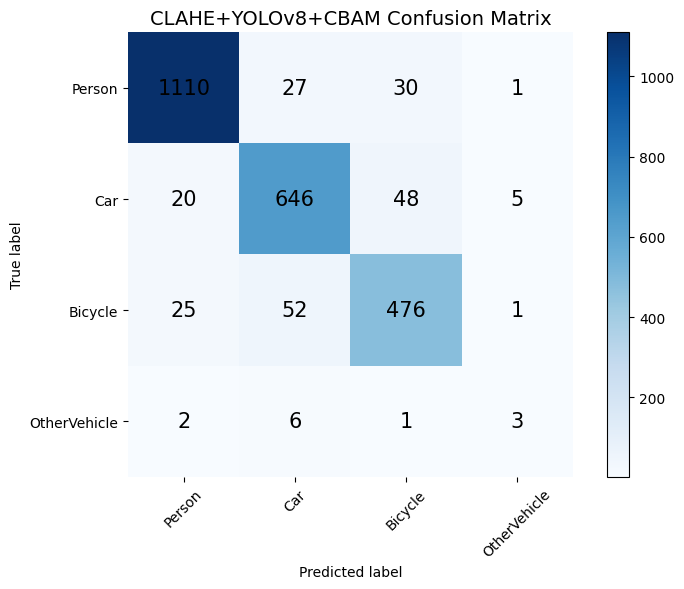

In [ ]:
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

true_dir = "../data/labels/val"
pred_dir = "runs/detect/val/labels"

y_true, y_pred = [], []

for fname in os.listdir(true_dir):
    if not fname.endswith(".txt"):
        continue

    true_path = os.path.join(true_dir, fname)
    pred_path = os.path.join(pred_dir, fname)

    with open(true_path) as f:
        true_classes = [int(line.strip().split()[0]) for line in f]

    if os.path.exists(pred_path):
        with open(pred_path) as f:
            pred_classes = [int(line.strip().split()[0]) for line in f]
    else:
        pred_classes = []

    y_true.extend(true_classes)
    y_pred.extend(pred_classes[:len(true_classes)])

class_names = ['Person', 'Car', 'Bicycle', 'OtherVehicle']
cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap="Blues", values_format=".0f", colorbar=True)

for text in disp.text_.ravel():
    text.set_color("black")
    text.set_fontsize(15)


for spine in ax.spines.values():
    spine.set_visible(False)

plt.title("CLAHE+YOLOv8+CBAM Confusion Matrix", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
metrics = model.val(
    data='dataset.yaml',
    split='test',
    imgsz=512
)


Ultralytics 8.3.137 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 52.4±13.4 MB/s, size: 88.4 KB)


val: Scanning /content/drive/MyDrive/Colab Notebooks/hit-uav/labels/test.cache... 571 images, 0 backgrounds, 0 corrupt: 100%|██████████| 571/571 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:10<00:00,  3.53it/s]


                   all        571       4780      0.881      0.834      0.881      0.601
                Person        355       2611      0.906      0.813      0.914      0.497
                   Car        267       1339       0.94      0.963      0.979      0.766
               Bicycle         86        796      0.902      0.854      0.927      0.604
          OtherVehicle         21         34      0.775      0.706      0.702      0.538
Speed: 0.3ms preprocess, 11.7ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to /content/ultralytics/runs/detect/val


In [ ]:
metrics.box.map      # mAP@0.5:0.95
metrics.box.map50    # mAP@0.5
metrics.box.map75    # mAP@0.75
metrics.box.maps     # mAP per class


array([    0.47479,     0.75624,     0.58861,      0.5313])

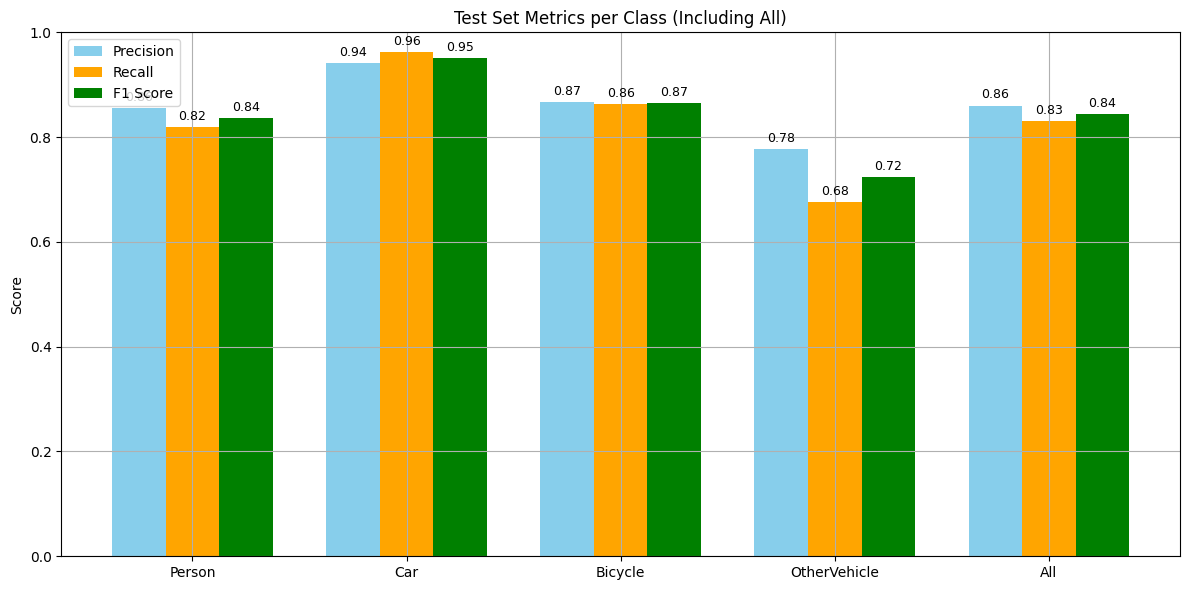

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

class_names = ['Person', 'Car', 'Bicycle', 'OtherVehicle', 'All']

# Precision, Recall, F1 values 
precision = list(metrics.box.p[:4])
recall = list(metrics.box.r[:4])
f1_scores = [2 * (p * r) / (p + r + 1e-6) for p, r in zip(precision, recall)]

# Add averages for 'All' classw
precision.append(np.mean(precision))
recall.append(np.mean(recall))
f1_scores.append(np.mean(f1_scores))

x = np.arange(len(class_names))
width = 0.25

plt.figure(figsize=(12, 6))
bars1 = plt.bar(x - width, precision, width, label='Precision', color='skyblue')
bars2 = plt.bar(x, recall, width, label='Recall', color='orange')
bars3 = plt.bar(x + width, f1_scores, width, label='F1 Score', color='green')

plt.xticks(x, class_names)
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Test Set Metrics per Class (Including All)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Function to annotate bars with their heights
def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.2f}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=9)

annotate_bars(bars1)
annotate_bars(bars2)
annotate_bars(bars3)

plt.savefig("test_metrics_with_all.png")
plt.show()


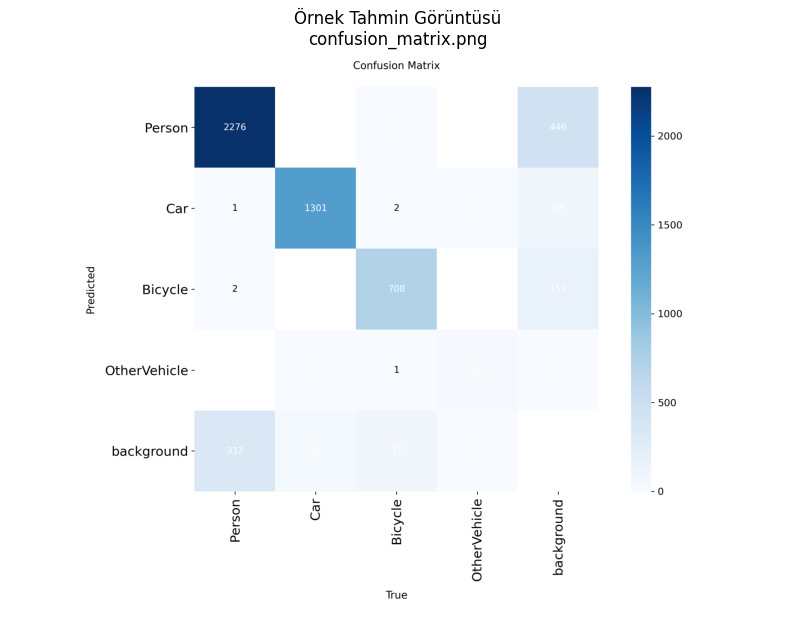

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Control predict folders
predict_base_dirs = ['runs/predict', 'runs/detect']
predict_paths = []

for base in predict_base_dirs:
    if os.path.exists(base):
        for folder in os.listdir(base):
            full_path = os.path.join(base, folder)
            if os.path.isdir(full_path):
                predict_paths.append(full_path)

# Check if any predict folder exists
if not predict_paths:
    raise FileNotFoundError("Prediction output folder not found. Please make sure that the model.predict(...) command has executed successfully.")

# Select the latest predict folder 
latest_predict_path = max(predict_paths, key=os.path.getmtime)

# List prediction images
image_files = [f for f in os.listdir(latest_predict_path) if f.endswith(('.jpg', '.png'))]
if not image_files:
    raise FileNotFoundError("Tahmin klasöründe görüntü bulunamadı.")

# Display a sample prediction image 
sample_image_path = os.path.join(latest_predict_path, image_files[0])
image = cv2.imread(sample_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.title(f"Örnek Tahmin Görüntüsü\n{image_files[0]}")
plt.show()
